In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [21]:
df = pd.read_csv('ultimodatasetsoja.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','cierre'])
df.head()

,cierre
fecha,
2004-05-01,221.0
2004-06-01,221.0
2004-07-01,219.0
2004-08-01,220.0
2004-09-01,220.0


In [22]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,cierre,weekday,month
fecha,,,
2004-05-01,221.0,5,5
2004-06-01,221.0,1,6
2004-07-01,219.0,3,7
2004-08-01,220.0,6,8
2004-09-01,220.0,2,9


In [23]:
df.describe()

,cierre,weekday,month
count,3875.000000,3875.000000,3875.000000
mean,259.920077,2.396129,6.479742
std,60.429399,1.718506,3.417860
min,146.000000,0.000000,1.000000
25%,221.000000,1.000000,4.000000
50%,257.000000,2.000000,6.000000
75%,300.900000,4.000000,9.000000
max,442.000000,6.000000,12.000000


In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
PASOS=7

# load dataset
values = df['cierre'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('cierre',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2,1,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3,1,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4,1,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0,1,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,1,1,-0.412162


In [26]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(3868, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,-0.412162


In [27]:
# split into train and test sets
values = newReframed.values
n_train_days = 249+253+250+248+248+248+246+246+242+242+242+243+247+247+243+166 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


(3823, 1, 21) (3823,) (45, 1, 21) (45,)


In [28]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [29]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Train on 3823 samples, validate on 45 samples
Epoch 1/100
3823/3823 [==============================] - 4s 1ms/step - loss: 0.2776 - mse: 0.1266 - val_loss: 0.1137 - val_mse: 0.0244
Epoch 2/100
3823/3823 [==============================] - 3s 849us/step - loss: 0.1660 - mse: 0.0441 - val_loss: 0.1208 - val_mse: 0.0215
Epoch 3/100
3823/3823 [==============================] - 2s 619us/st

45


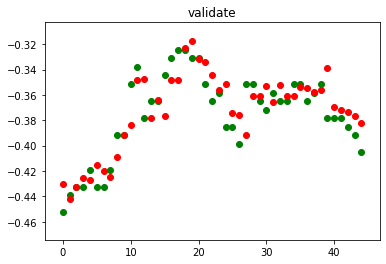

In [30]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

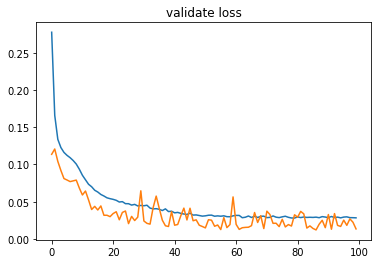

In [31]:



plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [32]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,226.999996,230.297618,-3.297622
1,229.000004,228.567530,0.432473
2,230.000007,229.989179,0.010828
3,230.000007,230.968479,-0.968471
4,231.999997,230.796949,1.203048
5,230.000007,232.557974,-2.557967
6,230.000007,231.844342,-1.844335
7,231.999997,231.121496,0.878501
8,235.999995,233.420737,2.579257
9,235.999995,236.042086,-0.042092


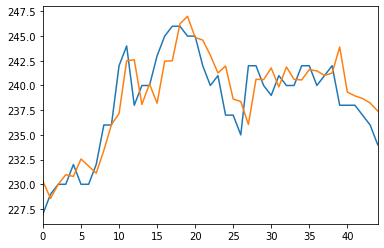

In [33]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [34]:
ultimosDias = df[3860:3875]
ultimosDias

,cierre,weekday,month,scaled
fecha,,,,
2019-09-09,239.0,0,9,-0.371621
2019-10-09,241.0,2,10,-0.358108
2019-11-09,240.0,5,11,-0.364865
2019-12-09,240.0,0,12,-0.364865
2019-09-13,242.0,4,9,-0.351351
2019-09-16,242.0,0,9,-0.351351
2019-09-17,240.0,1,9,-0.364865
2019-09-18,241.0,2,9,-0.358108
2019-09-19,242.0,3,9,-0.351351


In [35]:
scaledMerge=ultimosDias.drop('cierre',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 0.          9.         -0.37162149]
 [ 2.         10.         -0.35810804]
 [ 5.         11.         -0.36486483]
 [ 0.         12.         -0.36486483]
 [ 4.          9.         -0.35135126]
 [ 0.          9.         -0.35135126]
 [ 1.          9.         -0.36486483]
 [ 2.          9.         -0.35810804]
 [ 3.          9.         -0.35135126]
 [ 4.          9.         -0.37837827]
 [ 0.          9.         -0.37837827]
 [ 1.          9.         -0.37837827]
 [ 2.          9.         -0.38513505]
 [ 3.          9.         -0.39189184]
 [ 4.          9.         -0.40540528]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-09-18,0.0,9.0,-0.371621,2.0,10.0,-0.358108,5.0,11.0,-0.364865,0.0,...,-0.364865,4.0,9.0,-0.351351,0.0,9.0,-0.351351,1.0,9.0,-0.364865
2019-09-19,2.0,10.0,-0.358108,5.0,11.0,-0.364865,0.0,12.0,-0.364865,4.0,...,-0.351351,0.0,9.0,-0.351351,1.0,9.0,-0.364865,2.0,9.0,-0.358108
2019-09-20,5.0,11.0,-0.364865,0.0,12.0,-0.364865,4.0,9.0,-0.351351,0.0,...,-0.351351,1.0,9.0,-0.364865,2.0,9.0,-0.358108,3.0,9.0,-0.351351
2019-09-23,0.0,12.0,-0.364865,4.0,9.0,-0.351351,0.0,9.0,-0.351351,1.0,...,-0.364865,2.0,9.0,-0.358108,3.0,9.0,-0.351351,4.0,9.0,-0.378378
2019-09-24,4.0,9.0,-0.351351,0.0,9.0,-0.351351,1.0,9.0,-0.364865,2.0,...,-0.358108,3.0,9.0,-0.351351,4.0,9.0,-0.378378,0.0,9.0,-0.378378
2019-09-25,0.0,9.0,-0.351351,1.0,9.0,-0.364865,2.0,9.0,-0.358108,3.0,...,-0.351351,4.0,9.0,-0.378378,0.0,9.0,-0.378378,1.0,9.0,-0.378378
2019-09-26,1.0,9.0,-0.364865,2.0,9.0,-0.358108,3.0,9.0,-0.351351,4.0,...,-0.378378,0.0,9.0,-0.378378,1.0,9.0,-0.378378,2.0,9.0,-0.385135


In [36]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()


(2, 1, 21)
[[[ 1.          9.         -0.36486483  2.          9.
   -0.35810804  3.          9.         -0.35135126  4.
    9.         -0.37837827  0.          9.         -0.37837827
    1.          9.         -0.37837827  2.          9.
   -0.38513505]]

 [[ 2.          9.         -0.35810804  3.          9.
   -0.35135126  4.          9.         -0.37837827  0.
    9.         -0.37837827  1.          9.         -0.37837827
    2.          9.         -0.38513505  3.          9.
   -0.39189184]]]


In [37]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [38]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 1.          9.         -0.36486483  2.          9.
   -0.35810804  3.          9.         -0.35135126  4.
    9.         -0.37837827  0.          9.         -0.37837827
    1.          9.         -0.37837827  2.          9.
   -0.38513505]]

 [[ 2.          9.         -0.35810804  3.          9.
   -0.35135126  4.          9.         -0.37837827  0.
    9.         -0.37837827  1.          9.         -0.37837827
    2.          9.         -0.38513505  3.          9.
   -0.39189184]]]
pred 1 [[[ 2.          9.         -0.35810804  3.          9.
   -0.35135126  4.          9.         -0.37837827  0.
    9.         -0.37837827  1.          9.         -0.37837827
    2.          9.         -0.38513505  5.         12.
   -0.37686265]]

 [[ 2.          9.         -0.35810804  3.          9.
   -0.35135126  4.          9.         -0.37837827  0.
    9.         -0.37837827  1.          9.         -0.37837827
    2.          9.         -0.38513505  3.          9.
   -0.39189184]]]
pr

In [39]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.37686265], dtype=float32), array([-0.3731344], dtype=float32), array([-0.36581796], dtype=float32), array([-0.37008485], dtype=float32), array([-0.3682931], dtype=float32), array([-0.37149096], dtype=float32), array([-0.36957273], dtype=float32)]


array([[238.22431512],
       [238.77609473],
       [239.85892788],
       [239.22742848],
       [239.4926068 ],
       [239.01932519],
       [239.3032227 ]])

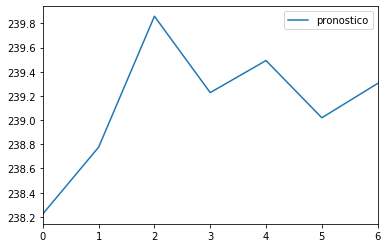

In [40]:
prediccion1SemanaOctubre = pd.DataFrame(inverted)
prediccion1SemanaOctubre.columns = ['pronostico']
prediccion1SemanaOctubre.plot()
prediccion1SemanaOctubre.to_csv('pronostico_multivariate.csv')


In [45]:
prediccion1SemanaOctubre

,pronostico
0,238.224315
1,238.776095
2,239.858928
3,239.227428
4,239.492607
5,239.019325
6,239.303223
